
Bus Voltages:
sourcebus: 1.00 pu, 0.00°
bus1: 1.00 pu, -0.00°
bus2: 1.00 pu, -0.00°
bus3: 1.00 pu, -30.43°
bus4: 1.00 pu, -30.43°
bus5: 0.84 pu, -31.41°
bus6: 0.84 pu, -31.41°

Power Flow Results for Transformers and Selected Buses:
Vsource.hv_source1:
  Power: P = -51.64 kW, Q = -17.47 kVAR
Vsource.hv_source2:
  Power: P = -51.63 kW, Q = -17.47 kVAR
Transformer.transformer1:
  Power: P = 18.31 kW, Q = 6.52 kVAR
Transformer.transformer2:
  Power: P = 18.29 kW, Q = 6.52 kVAR

Line Currents:
Line.lv_line1:
  Current: Magnitude = 84.14 A, Angle = -49.60°
Line.lv_line2:
  Current: Magnitude = 84.10 A, Angle = -49.61°
Line.switch_connection:
  Current: Magnitude = 13.99 A, Angle = 130.36°


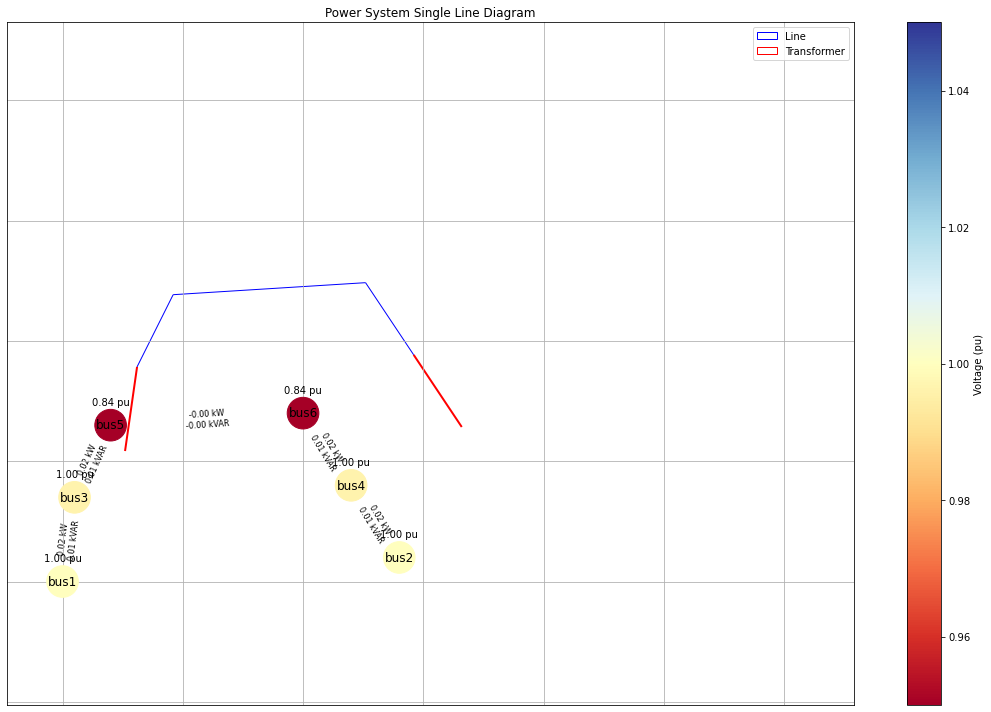

In [5]:
# Cell 1: Import libraries
import opendssdirect as dss
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.patches import Circle, Patch
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 10]

main_path = r"C:\Users\47939\Desktop\te"
dss.Basic.DataPath(main_path)
dss.Text.Command(f'Compile {main_path}\\test.dss')

# Load bus coordinates from CSV
coordinates_df = pd.read_csv(f"{main_path}\\Network_coordinate.csv", delimiter=',', names=['Bus', 'X', 'Y'])


bus_coord_dict = {bus.lower(): (float(x), float(y)) for bus, x, y in zip(coordinates_df.Bus, coordinates_df.X, coordinates_df.Y)}

# Init OpenDSS 
dss.Basic.DataPath(main_path)
dss.Text.Command(f'Compile {main_path}\\test.dss')
dss.Text.Command('set mode=daily')
dss.Text.Command('set stepsize=1h')
dss.Text.Command('solve')

#create network graph
def create_network_graph(bus_coordinates):
    """Create a NetworkX graph from OpenDSS circuit elements."""
    G = nx.Graph()
    positions = {}

    for bus in dss.Circuit.AllBusNames():
        if bus.lower() == 'sourcebus':
            continue  # Skip source bus
        base_bus = bus.split('.')[0].lower()
        
        if base_bus in bus_coordinates:  
            x, y = bus_coordinates[base_bus]
            dss.Circuit.SetActiveBus(bus)
            v_pu, v_ang = dss.Bus.puVmagAngle()[0], dss.Bus.puVmagAngle()[1]
            G.add_node(bus, voltage_pu=v_pu, voltage_ang=v_ang, type='bus')
            positions[bus] = (x, y)
    
    
    for elem in dss.Circuit.AllElementNames():
        dss.Circuit.SetActiveElement(elem)
        bus_names = dss.CktElement.BusNames()
        
        if len(bus_names) >= 2:
            from_bus, to_bus = bus_names[0], bus_names[1]
            if 'sourcebus' in from_bus.lower() or 'sourcebus' in to_bus.lower():
                continue  # Skip edges connected to source bus
            
            if from_bus in positions and to_bus in positions:
                powers = dss.CktElement.Powers()
                if len(powers) >= 2:
                    p_kw, q_kvar = powers[0] / 1000, powers[1] / 1000
                    G.add_edge(from_bus, to_bus, name=elem, type='line' if elem.lower().startswith('line') else 'transformer', p_kw=p_kw, q_kvar=q_kvar)
    
    return G, positions

# draw the network
def draw_network(G, bus_positions):
    """Draws the power system network with voltage and power flow details."""
    if not G.nodes():
        print("Error: Graph has no nodes!")
        return None, None
    
    fig, ax = plt.subplots(figsize=(15, 10))
    

    voltage_values = [G.nodes[node]['voltage_pu'] for node in G.nodes()]
    nodes = nx.draw_networkx_nodes(G, bus_positions, node_color=voltage_values, node_size=1000, cmap=plt.cm.RdYlBu, vmin=0.95, vmax=1.05)
    

    edge_colors, edge_widths = [], []
    for u, v, data in G.edges(data=True):
        edge_colors.append('red' if data['type'] == 'transformer' else 'blue')
        edge_widths.append(2 if data['type'] == 'transformer' else 1)
    
    if G.edges():
        nx.draw_networkx_edges(G, bus_positions, edge_color=edge_colors, width=edge_widths)
    

    nx.draw_networkx_labels(G, bus_positions)
    edge_labels = {(u, v): f"{d['p_kw']:.2f} kW\n{d['q_kvar']:.2f} kVAR" for u, v, d in G.edges(data=True)}
    nx.draw_networkx_edge_labels(G, bus_positions, edge_labels, font_size=8)
    

    plt.colorbar(nodes, label='Voltage (pu)')
    ax.legend(handles=[Patch(facecolor='none', edgecolor='blue', label='Line'), Patch(facecolor='none', edgecolor='red', label='Transformer')])
    
    plt.title('Power System Single Line Diagram')
    plt.axis('equal')
    plt.grid(True)
    

    for node in G.nodes():
        x, y = bus_positions[node]
        voltage = G.nodes[node]['voltage_pu']
        plt.annotate(f'{voltage:.2f} pu', (x, y), xytext=(0, 20), textcoords='offset points', ha='center')
    
    plt.tight_layout()
    return fig, ax

#  display the network
G, bus_positions = create_network_graph(bus_coord_dict)
fig, ax = draw_network(G, bus_positions)

# Display bus voltages
print("\nBus Voltages:")
for bus in dss.Circuit.AllBusNames():
    dss.Circuit.SetActiveBus(bus)
    v_pu, v_ang = dss.Bus.puVmagAngle()[0], dss.Bus.puVmagAngle()[1]
    print(f"{bus}: {v_pu:.2f} pu, {v_ang:.2f}°")

# Display power flow for transformers and source buses
print("\nPower Flow Results for Transformers and Selected Buses:")
for elem in dss.Circuit.AllElementNames():
    dss.Circuit.SetActiveElement(elem)
    if elem.lower().startswith('transformer') or elem.lower().endswith('source1') or elem.lower().endswith('source2'):
        powers = dss.CktElement.Powers()
        if len(powers) >= 2:
            p_kw, q_kvar = powers[0], powers[1] 
            print(f"{elem}:\n  Power: P = {p_kw:.2f} kW, Q = {q_kvar:.2f} kVAR")

# Display currents for lines only
print("\nLine Currents:")
for elem in dss.Circuit.AllElementNames():
    if elem.lower().startswith('line'):
        dss.Circuit.SetActiveElement(elem)
        currents = dss.CktElement.Currents()
        current_mag = np.sqrt(currents[0]**2 + currents[1]**2)
        current_ang = np.degrees(np.arctan2(currents[1], currents[0]))
        print(f"{elem}:\n  Current: Magnitude = {current_mag:.2f} A, Angle = {current_ang:.2f}°")
